# Gaussian States Visualization — Annotated Edition

*Enhanced on 2025-08-12.*

This version adds clear explanations, a quick start guide, and pointers for interpreting each figure. The original code is preserved.


## Overview & Goals

This notebook illustrates **continuous‑variable (CV) Gaussian states** (e.g., vacuum, coherent, squeezed, and thermal states) in phase space.
We focus on practical intuition:

- What each parameter (displacement, squeezing magnitude/angle, thermal noise) *does* to the state
- How the **covariance matrix** encodes noise and correlations
- How to **read plots** like Wigner functions and covariance ellipses
- Reproducible setup so others can run this easily


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, sinm, cosm
from mpl_toolkits.mplot3d import Axes3D 
from ipywidgets import interact, ToggleButtons, FloatSlider


## Background: What is a Gaussian state?

In continuous variables (e.g., modes of the electromagnetic field), a **Gaussian state** is fully specified by its **first moments** (displacement vector) and **second moments** (covariance matrix) of the quadratures \((\hat x,\hat p)\).

- Displacement shifts the state's center in phase space.
- Squeezing redistributes noise between conjugate quadratures while preserving the uncertainty principle.
- Thermal noise increases the overall radius/area of the noise ellipse.

If your code uses a covariance matrix \(\mathbf V\) and mean vector \(\boldsymbol d\), the Wigner function takes the general Gaussian form
\[
W(\boldsymbol \xi)=\frac{\exp\!\Big(-\tfrac12(\boldsymbol \xi-\boldsymbol d)^\top \mathbf V^{-1}(\boldsymbol \xi-\boldsymbol d)\Big)}{2\pi\sqrt{\det \mathbf V}},
\]
up to convention-dependent normalization factors.


In [9]:
def Wigner_function(r, r_bar, sigma, n=1):
    # Calculate the Wigner function for a Gaussian state
    # r: phase space vector (2n-dimensional)
    # r_bar: displacement vector (2n-dimensional)
    # sigma: covariance matrix (2n x 2n)
    # n: number of modes (default is 1 for single mode)

    d = r - r_bar  # Displacement in phase space
    W = 1/(2*np.pi)**n
    W /= np.sqrt(np.linalg.det(sigma))
    W *= np.exp(-0.5 * d.T @ np.linalg.inv(sigma) @ d)
    return W


## How to Read the Plots

- **Wigner heatmaps / contours**: The center shows the state's displacement; oval shape and tilt reflect the covariance matrix (squeezing and correlations).
- **Quadrature histograms**: Narrower distribution along one axis and broader along the conjugate indicate squeezing.
- **Covariance ellipses**: Principal axes align with eigenvectors of the covariance; axis lengths relate to eigenvalues (noise along those directions).


In [44]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection

# ---- Grid utils (reuse these for multiple plots) ----
def make_grid(xlim=5, ylim=5, num=200):
    xL = np.linspace(-xlim, xlim, num, dtype=np.float64)
    yL = np.linspace(-ylim, ylim, num, dtype=np.float64)
    X, Y = np.meshgrid(xL, yL, indexing="ij")
    return xL, yL, X, Y

# ---- Slow (reference) version: list loop calling your scalar Wigner_function ----
@timeit
def generate_Wigner_function_list(r_bar=None, sigma=None, n=1, xlim=5, ylim=5, num=100):
    if r_bar is None: r_bar = np.array([0.0, 0.0])
    if sigma is None: sigma = np.eye(2) / 2
    xL = np.linspace(-xlim, xlim, num)
    yL = np.linspace(-ylim, ylim, num)
    with timed("wigner-eval(list)"):
        rL = [np.array([x, y]) for x in xL for y in yL]
        WL = np.array([Wigner_function(r, r_bar, sigma, n) for r in rL]).reshape(num, num)
    return xL, yL, WL

def as_vec2(v):
    """Return a shape-(2,) float vector. 
    - None or scalar 0 -> [0., 0.]
    - Scalar nonzero   -> [v, 0.]  (so you can still encode a displacement along x)
    - 2-vector/2x1/1x2 -> flattened (2,)
    """
    if v is None:
        return np.array([0.0, 0.0])
    a = np.asarray(v, dtype=float)
    if a.ndim == 0:
        return np.array([0.0, 0.0]) if float(a) == 0.0 else np.array([float(a), 0.0])
    a = a.reshape(-1)
    if a.size != 2:
        raise ValueError(f"r_bar must be length-2, got shape {a.shape}")
    return a

def as_mat2x2(M):
    """Return a shape-(2,2) float matrix."""
    if M is None:
        return np.eye(2, dtype=float)/2
    A = np.asarray(M, dtype=float)
    A = A.reshape(2, 2)
    return A

# ---- Fast (preferred): vectorized without explicit inverse ----
@timeit
def generate_Wigner_function_fast(r_bar=None, sigma=None, n=1, xlim=5, ylim=5, num=200, X=None, Y=None):
    r_bar = as_vec2(r_bar)
    sigma = as_mat2x2(sigma)

    if X is None or Y is None:
        xL = np.linspace(-xlim, xlim, num, dtype=np.float64)
        yL = np.linspace(-ylim, ylim, num, dtype=np.float64)
        X, Y = np.meshgrid(xL, yL, indexing="ij")
    else:
        xL, yL = X[:, 0], Y[0, :]

    Delta = np.stack((X - r_bar[0], Y - r_bar[1]), axis=0)  # (2, num, num)
    M = Delta.reshape(2, -1)

    with timed("solve-2xN"):
        Z = np.linalg.solve(sigma, M)

    quad = np.sum(M * Z, axis=0).reshape(X.shape)
    norm = 1.0 / (2*np.pi*np.sqrt(np.linalg.det(sigma)))
    with timed("wigner-exp"):
        W = norm * np.exp(-0.5 * quad)
    return xL, yL, W

In [30]:
# ---- Unified front-end ----
def generate_Wigner_function(r_bar=None, sigma=None, n=1, xlim=5, ylim=5, num=200, method="fast", X=None, Y=None):
    if method == "list":
        return generate_Wigner_function_list(r_bar, sigma, n, xlim, ylim, num)
    elif method == "fast":
        return generate_Wigner_function_fast(r_bar, sigma, n, xlim, ylim, num, X=X, Y=Y)
    else:
        raise ValueError("method must be 'fast' or 'list'")

In [45]:
# ---- 2D contour ----
def plot_wigner_function(r_bar=None, sigma=None, n=1, xlim=5, ylim=5, num=200, method="fast", X=None, Y=None):
    xL, yL, WL = generate_Wigner_function(r_bar, sigma, n, xlim, ylim, num, method, X, Y)
    with timed("plot-2d"):
        plt.figure(figsize=(8, 6))
        plt.contourf(xL, yL, WL, levels=50)
        plt.colorbar(label='Wigner Function Value')
        plt.title(f'Wigner (method={method})')
        plt.xlabel('x'); plt.ylabel('p'); plt.grid(True, alpha=0.3)
        plt.show()

# ---- 3D surface ----
def plot_wigner_function_3D(r_bar=None, sigma=None, n=1, xlim=5, ylim=5, num=200, method="fast", X=None, Y=None):
    xL, yL, WL = generate_Wigner_function(r_bar, sigma, n, xlim, ylim, num, method, X, Y)
    Xg, Yg = (np.meshgrid(xL, yL, indexing="ij") if (X is None or Y is None) else (X, Y))
    with timed("plot-3d"):
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(Xg, Yg, WL, edgecolor='none')
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Wigner Function Value')
        ax.set_title(f'Wigner (3D, method={method})')
        ax.set_xlabel('x'); ax.set_ylabel('p'); ax.set_zlabel('Wigner Value')
        plt.show()

#### Example Plots

[timeit] wigner-eval(list): 0.2472 s
[timeit] generate_Wigner_function_list: 0.2493 s


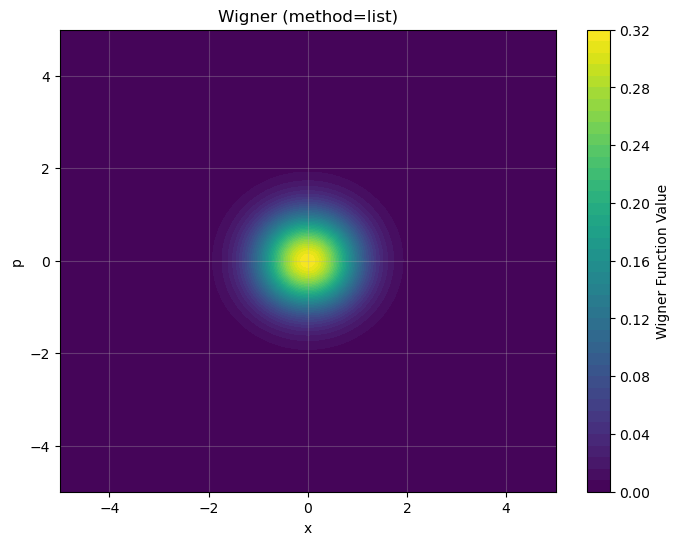

[timeit] plot-2d: 0.0699 s
[timeit] solve-2xN: 0.0006 s
[timeit] wigner-exp: 0.0001 s
[timeit] generate_Wigner_function_fast: 0.0016 s


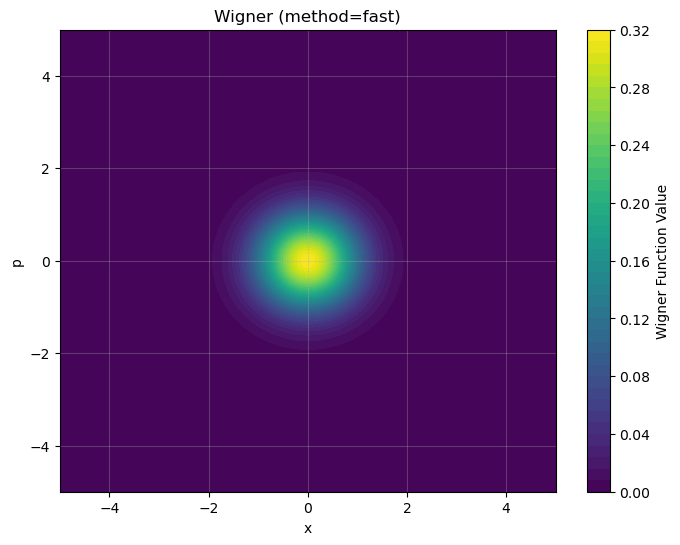

[timeit] plot-2d: 0.0961 s


"\nplot_wigner_function_3D(\n    r_bar=np.array([-1.0, 1.0]) / 2,\n    sigma=np.array([[1.0, 0.5],\n                    [0.5, 1.0]]), method = 'fast')\nplot_wigner_function_3D(\n    r_bar=np.array([-1.0, 1.0]) / 2,\n    sigma=np.array([[1.0, 0.5],\n                    [0.5, 1.0]]), method = 'list')\n"

In [46]:
# ——— Example usage ———
plot_wigner_function(method ='list')  # default: r_bar=[0,0], sigma=I/2
plot_wigner_function(method='fast')  # default: r_bar=[0,0], sigma=I/2
"""
plot_wigner_function_3D(
    r_bar=np.array([-1.0, 1.0]) / 2,
    sigma=np.array([[1.0, 0.5],
                    [0.5, 1.0]]), method = 'fast')
plot_wigner_function_3D(
    r_bar=np.array([-1.0, 1.0]) / 2,
    sigma=np.array([[1.0, 0.5],
                    [0.5, 1.0]]), method = 'list')
"""

### Single-mode Squeezing and Double-mode Squeezing

<!-- auto-annotation -->
**What this cell does — Functions defined:** `squeeze_matrix_single, squeeze_matrix_double`

- Use `@timeit` above heavy functions to profile runtime.
- Consider docstrings for each function: purpose, parameters, returns.
- If a function creates plots, ensure it sets titles and axis labels.


In [22]:
# Single-mode Gaussian operations

S = lambda theta : np.array([[np.cos(theta), np.sin(theta)], 
                            [np.sin(theta), -np.cos(theta)]])

def squeeze_matrix_single(r=0, theta=0):
    r_bar = 0
    sigma = 0.5*np.cosh(2*r)*np.eye(2)
    sigma += -0.5*np.sinh(2*r)*S(theta)
    
    return r_bar, sigma

# Double-mode Gaussian operations

def squeeze_matrix_double(r=0, theta=0):
    X = np.array([[0,1],[1,0]])
    r_bar = 0
    sigma = 0.5*np.cosh(2*r)*np.eye(4)
    sigma += -0.5*np.sinh(2*r)*np.kron(X,S(theta))

    return r_bar, sigma

#print(squeeze_matrix_single(0,np.pi/2)[1])
#print(squeeze_matrix_double(0,np.pi/2)[1])


### Interactive Display: Single-Mode Squeezing

<!-- auto-annotation -->
**What this cell does — Functions defined:** `interactive_wigner`

- Use `@timeit` above heavy functions to profile runtime.
- Consider docstrings for each function: purpose, parameters, returns.
- If a function creates plots, ensure it sets titles and axis labels.


In [ ]:
@interact(
    view = ToggleButtons(options=['Contour','3D'], description='View:'),
    r    = FloatSlider(min=0, max=2, step=0.05, value=0, description='squeeze r'),
    θ    = FloatSlider(min=0, max=2*np.pi, step=0.1, value=0, description='θ (rad)')
)

def interactive_wigner(view, r, θ):
    r_bar, sigma = squeeze_matrix_single(r, θ)
    if view == 'Contour':
        plot_wigner_function(r_bar, sigma)
    else:
        plot_wigner_function_3D(r_bar, sigma)


interactive(children=(ToggleButtons(description='View:', options=('Contour', '3D'), value='Contour'), FloatSli…

## Further Reading

- Weedbrook *et al.*, **Gaussian quantum information**, *Rev. Mod. Phys.* 84, 621 (2012).
- Ferraro, Olivares, Paris, **Gaussian States in Quantum Information** (Bibliopolis, 2005).
- Leonhardt, **Measuring the Quantum State of Light** (Cambridge, 1997).


## Conclusion

You should now be able to connect **parameters** (displacement, squeezing, noise) to **geometric features** in phase space.
If anything still feels unclear, consider adding a brief note under each figure stating the *parameter values* and a one‑line *takeaway*.
